In [2]:
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams['figure.figsize'] = (7.0, 5.0)

## Susceptibility, Absorption and Phase Delay for $\mathrm{D}_2(5^2\mathrm{S}^{1/2}\rightarrow 5^2\mathrm{P}^{3/2})$

In [30]:
# Code source OHR LAHAD. Modified.
# Calculate and plot absorption and refraction of probe
# The system is a two level system
# The probe laser is tuned
# to the D2 transition.
# All in MKS

#### CONSTANTS (MKS) ####
n0=1.000293                 # Air refractive index
hbar=1.054571726e-34        # Reduced planck constant (J*s)
eps0=8.854187817e-12        # Vacuum permittivity [C^2*s^2/(kg*m^3)]
c=2.99792e8                 # This one is easy to guess :p
m=1.4431606e-25             # Rb87 mass [kg] (from Steck)
kb=1.386488e-23             # Boltzmann constant [J/K]

#### Parameters to insert: ####
nT=30001
Temp=22+(273.15)                                         # Input temp.@Celcius, output@Kelvin
L=0.179+0.35e-7                                                  # Length of cell [m]
F1probe=2; m1probe=2;                                    # Ground state (Fg,mg)
F2probe=2; m2probe=3;                                    # Excited state (Fe,me)
gammaceg=0e4*(2*np.pi)                                   # Coherence dephasing rate of g<->e transition
gammacsg=6.0666e6*(2*np.pi)                              # Coherence dephasing rate of s<->g transition
nuclearSpin=3/2                                          # Nuclear spin for 87Rb

det=(2*np.pi)*0.5e9*np.linspace(-1,1,1201)                 # Probe detuning

MeltTemp = 39.31+273.15                                  # Rb melting point
if Temp > MeltTemp:                                      # Atom density [1/m^3] in terms of pressure (from Steck)
    density=10**(2.881+4.312-4040/Temp)*133.323/(kb*Temp)# Liquid phase
else:
    density=10**(2.881+4.857-4215/Temp)*133.323/(kb*Temp)

vT=np.sqrt(kb*Temp/m)       # Thermal velocity [m/s]   
    
def D2_CG(F1probe,F2probe,m1,m2):
    '''
    Data tables for dipole matrix elements for D2 transitions (From Steck),
    expressed as multiples of <J=1/2||er||J'=3/2>. Input (F1,F2,m1,m2).
    Sigma+ polarized light.
    '''
    ClebschGordanF_1 = np.array([[0,0,np.sqrt(1/6.)],
                 [np.sqrt(5/24.),0,np.sqrt(5/24.)],
                 [np.sqrt(1/8.),np.sqrt(1/4.),np.sqrt(1/24.)]])

    ClebschGordanF_2 = np.array([[0,0,0,0,0],
                        [np.sqrt(1/120.),0,0,np.sqrt(1/20.),np.sqrt(1/40.)],
                        [np.sqrt(1/8.),np.sqrt(1/12.),0,np.sqrt(1/12.),np.sqrt(1/8.)],
                        [np.sqrt(1/5.),np.sqrt(1/3.),np.sqrt(1/2.),np.sqrt(1/30.),np.sqrt(1/10.)]])
    
    if m2 != m1+1:   # Sigma+
        return 0
    
    if F1probe == 1:
        return np.sum(ClebschGordanF_1[F2probe,:])
    if F1probe == 2:
        return np.sum(ClebschGordanF_2[F2probe,:])


# Load D1 and D2 matrix elements:
#load('D:\Box Sync\Lab\Calculations\Parameters\Dipole Matrix elements D1.mat'); # Data tables for dipole matrix elements for D1 transitions,
    # expressed as multiples of <J=1/2||er||J'=1/2>. Input (F1,F2,m1,m2).
    # See D1transitionmatrixelements.m 

cumulprob=np.linspace(1e-4,1-1e-4,nT+1)
vbins=norm.ppf(cumulprob,loc=0,scale=vT)
v=vbins[0:-1]+0.5*np.diff(vbins)

In [31]:
#### D1:
#  probeDecay=36.129e6;   # Decay rate [s^-1]
#  probeGamma=5.75e6 *(2*pi);  # Natural line width [1/s]
#  probeLambda=794.978851e-9;  # Wavelength in air [m]
#  d0=2.5377e-29 ;   # <J=1/2||er||J=1/2>  [C*m]  For D1
#  CG=D1(F1probe,F2probe,m1probe,m2probe); # Matrix element ratio, "Clebsch-Gordan"
#  probeDipole=d0*CG; # Dipole matrix element
#  kprobe=2*pi/probeLambda; # Probe wavenumber

#### D2:
probeDecay=38.117e6                        # Decay rate [s^-1]
probeGamma=6.0666e6 *(2*np.pi)             # Natural Line Width [1/s]
probeLambda=780.033330e-9                  # Wavelength in air [m]
kprobe=2*np.pi/probeLambda                 # Probe wavenumber
d0=3.58424e-29                             # <J=1/2||er||J=3/2>  [C*m]  for D2
CG=D2_CG(F1probe,F2probe,m1probe,m2probe)  # Matrix element ratio, "Clebsch-Gordan"
probeDipole=d0*CG;                         # Dipole matrix element

In [32]:
absorption_v=np.zeros((nT,det.shape[0]));
refractiveIndex=np.zeros((nT,det.shape[0]));

$$
\chi_{F_g\rightarrow F_e}(\Delta) = C_{F_g\rightarrow F_e}^2 d_0^2 \mathcal{N} \frac{1}{\hbar\epsilon_0}\frac{1}{2(2\mathcal{I}+1)}\, \frac{\mathrm{i}}{\gamma + \mathrm{i}\Delta}
$$

$d_0=\langle J=1/2\,||\,er\,||\,J=3/2\rangle$ is the $\mathrm{D}_2(5^2\mathrm{S}^{1/2}\rightarrow 5^2\mathrm{P}^{3/2})$ transition dipole matrix element.

$\Delta=\omega_\mathrm{L}-\omega_0$

$2(2\mathcal{I}+1)$  is the degeneracy of the ground state of the particular isotope ($\mathcal{I}=3/2$ for $^{87}\mathrm{Rb}$, $\mathcal{I}$ is the nuclear spin). The degeneracy appears as we are assuming that the population is evenly distributed amongst the ground-state Zeeman sublevels. 

$\gamma=\frac{\Gamma}{2}+\gamma_\mathrm{dephasing}$

In [33]:
for l in xrange(0,nT): # Runs over velocity groups

    detuning=det-kprobe*v[l]; # Probe detuning
 
    gammaeg=probeGamma/2+gammaceg; # Probe width
    Gammaeg=gammaeg-1j*detuning; 
 
    chieg=(density*probeDipole**2/(eps0*hbar*2*(2*nuclearSpin+1)))*1j/Gammaeg;
    absorption_v[l,:]=kprobe*np.imag(chieg); # per length [1/m]
    refractiveIndex[l,:]=1+1/2.*np.real(chieg);

$\alpha_{F_g\rightarrow F_e}(\Delta)=k\, \mathrm{Im}[\chi_{F_g\rightarrow F_e}(\Delta)]$

$n\approx 1+ \frac{\mathrm{Re}[\chi(\Delta)]}{2}$

In [34]:
absorption=np.mean(absorption_v,axis=0);
refind=np.mean(refractiveIndex,axis=0);
OD=absorption*L;

$$
\mathbf{E}(z,t)=\mathbf{E}_0 \mathrm{e}^{-L_\mathrm{depth} +\mathrm{i}\,\Delta \phi}
$$

$L_\mathrm{depth} = k_0 \alpha_{F_g\rightarrow F_e}(\Delta) L_\mathrm{cell}$

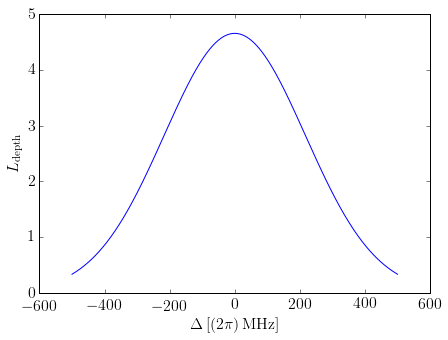

In [35]:
plt.figure()
plt.plot(det/(2*np.pi)/1e6,OD)
plt.xlabel(r'$\Delta\, [(2\pi)\, \mathrm{MHz}]$',fontsize=16)
plt.ylabel(r'$L_\mathrm{depth}$',fontsize=16)
plt.tick_params(labelsize=16)

$\mathcal{T}=\mathrm{e}^{-L_\mathrm{depth}} $

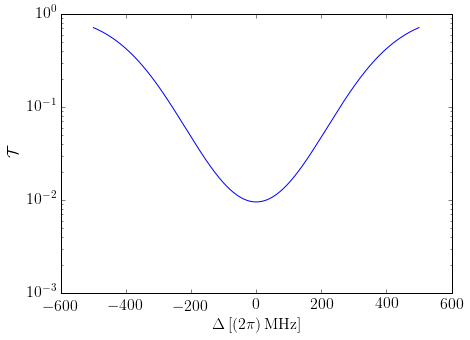

In [36]:
plt.figure()
plt.plot(det/(2*np.pi)/1e6,np.exp(-OD))
plt.xlabel(r'$\Delta\, [(2\pi)\, \mathrm{MHz}]$',fontsize=16)
plt.ylabel(r'$\mathcal{T}$',fontsize=16)
plt.tick_params(labelsize=16)
plt.yscale('log')

$n\approx 1+ \frac{\mathrm{Re}[\chi(\Delta)]}{2}$

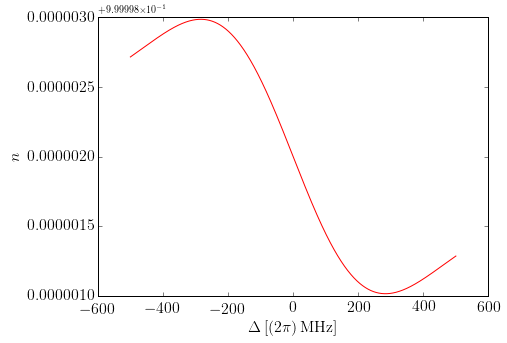

In [37]:
plt.figure()
plt.plot(det/(2*np.pi)/1e6,refind,'r')
plt.xlabel(r'$\Delta\, [(2\pi)\, \mathrm{MHz}]$',fontsize=16)
plt.ylabel(r'$n$',fontsize=16)
plt.tick_params(labelsize=16)

$\Delta\phi = k_0 (n-1)L_\mathrm{cell}$

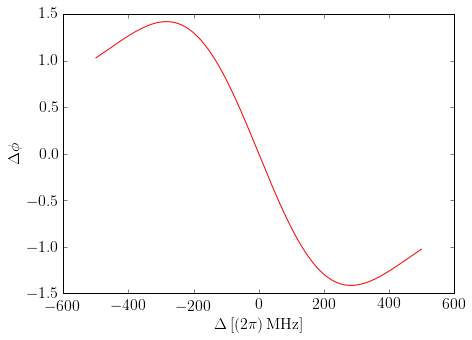

In [38]:
plt.figure()
plt.plot(det/(2*np.pi)/1e6,kprobe*(refind-1)*L,'r')
plt.xlabel(r'$\Delta\, [(2\pi)\, \mathrm{MHz}]$',fontsize=16)
plt.ylabel(r'$\Delta\phi$',fontsize=16)
plt.tick_params(labelsize=16)

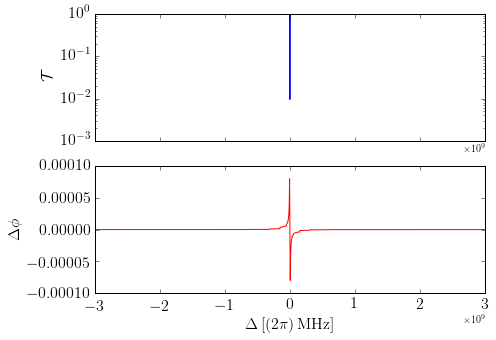

In [18]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(det/(2*np.pi)/1e6,np.exp(-OD))
plt.ylabel(r'$\mathcal{T}$',fontsize=16)
plt.tick_params(labelsize=16,labelbottom=False)
plt.yscale('log')

plt.subplot(2,1,2)
plt.plot(det/(2*np.pi)/1e6,kprobe*(refind-1)*L,'r')
plt.xlabel(r'$\Delta\, [(2\pi)\, \mathrm{MHz}]$',fontsize=16)
plt.ylabel(r'$\Delta\phi$',fontsize=16)
plt.tick_params(labelsize=16)

spline interpolation of the results and shift

In [19]:
freqD2 = 384.2304844685e12             # 5^2 S_{1/2} --->  5^2 P_{3/2} transition frequency (Hz)
detF2_F3 = +193.7407e6                 # F=2 ---> F=3 detuning from freqD2 (Hz)
detF2_F2 = -72.9112e6                  # F=2 ---> F=2 detuning from freqD2 (Hz)
detF2_F1 = -229.8518e6                 # F=2 ---> F=1 detuning from freqD2 (Hz)

In [20]:
ODinterp = interp1d(det-detF2_F3*2*np.pi, OD)
phaseshiftInterp = interp1d(det-detF2_F3*2*np.pi,kprobe*(refind-1)*L)

## Cavity with glass cell

### Circulating Field

$$
\frac{\tilde E_\mathrm{circ}}{\tilde E_\mathrm{inc}}=\frac{\mathrm{i}t_1}{1-\tilde g_{rt}(\omega_L)} 
$$

### Transmitted Field

$$
\frac{\tilde E_\mathrm{trans}}{\tilde E_\mathrm{inc}}=-\frac{t_1 t_2}{\sqrt{r_1 r_2}} \frac{\sqrt{\tilde g_{rt}(\omega_L)}}{1-\tilde g_{rt}(\omega_L)}
$$

- $\alpha_0$ absorption coefficient for internal losses
- $k_0$ wavevector of incident light
- $d$ cavity lenght
- $r_i, t_i\, (i=1,2)$ mirror reflectance and transmitance, respectively

$$
\tilde g_{rt}(\omega_L) = r_1 r_2 \exp(- \alpha_0 \,2-\mathrm{i} \omega_L \frac{2d}{c}+\mathrm{i}\cos^{-1}\pm\sqrt{g_1 g_2})
$$

- $g_i=1-d/C_i$ where $C_i$ is the curvature radius of the mirror.

In the following
$$
\Delta = \omega_L - \omega_0 \quad \rightarrow \quad \omega_L=\Delta+\omega_0 
$$
where $\omega_0$ is the frequency of $5^2 S_{1/2} \rightarrow  5^2 P_{3/2}$ transition (384.230 484 468 5(62) THz)

In [51]:
R1 = 0.9
R2 = 0.995

r1 = np.sqrt(R1)
t1 = np.sqrt(1-R1)

r2 = np.sqrt(R2)
t2 = np.sqrt(1-R2)

C1 = 0.1
C2 = 0.1
d = 0.179+0.35e-7 # cavity length in meters

g1 = 1-(d/C1)
g2 = 1-(d/C2)

alpha0 = 2*0.01 # cell glass losses

freqD2 = 384.2304844685e12             # 5^2 S_{1/2} --->  5^2 P_{3/2} transition frequency (Hz)
detF2_F3 = +193.7407e6                 # F=2 ---> F=3 detuning from freqD2 (Hz)
detF2_F2 = -72.9112e6                  # F=2 ---> F=2 detuning from freqD2 (Hz)
detF2_F1 = -229.8518e6                 # F=2 ---> F=1 detuning from freqD2 (Hz)

FSR = c/(2*d)

grt = lambda det: r1*r2*np.exp(-alpha0*2-1j*(det+freqD2)*2*d/c+1j*np.arccos(-np.sqrt(g1*g2)))
Ecirc = lambda det: t1/(1-grt(det+freqD2))
Etrans = lambda det: t1*t2*np.sqrt(grt(det+freqD2))/((1-grt(det+freqD2))*np.sqrt(r1*r2))

print 'FSR = %.3f GHz' %(FSR/1e9)

FSR = 0.837 GHz


In [57]:
det = np.linspace(-0.5,0.5,10001)*1e9*2*np.pi       # (-5 THz,5 THz) detuning

Detuning of the cavity resonances and $D2$ transitions 

In [96]:
print 'detuning D2:F2->F3 = %.3f MHz'% (((458833+np.arccos(-np.sqrt(g1*g2))/np.pi)*FSR-(detF2_F3+freqD2))/1e6)
print 'detuning D2:F2->F2 = %.3f MHz'% (((458833+np.arccos(-np.sqrt(g1*g2))/np.pi)*FSR-(detF2_F2+freqD2))/1e6)
print 'detuning D2:F2->F1 = %.3f MHz'% (((458833+np.arccos(-np.sqrt(g1*g2))/np.pi)*FSR-(detF2_F1+freqD2))/1e6)

detuning D2:F2->F3 = 250.985 MHz
detuning D2:F2->F2 = 517.637 MHz
detuning D2:F2->F1 = 674.577 MHz


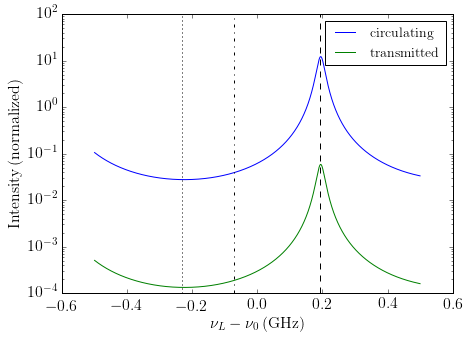

In [97]:
w = det
plt.plot(w/(2*np.pi*1e9),np.absolute(Ecirc(w))**2, label=r'$\mathrm{circulating}$')
plt.plot(w/(2*np.pi*1e9),np.absolute(Etrans(w))**2, label=r'$\mathrm{transmitted}$')
plt.yscale('log')
plt.xlabel(r'$\nu_L-\nu_0 \, (\mathrm{GHz})$',fontsize=16)
plt.ylabel(r'$\mathrm{Intensity\, (normalized)}$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14)
plt.axvline((detF2_F3)/1e9,linestyle='dashed',color='k')
plt.axvline((detF2_F2)/1e9,linestyle='dashdot',color='k')
plt.axvline((detF2_F1)/1e9,linestyle='dotted',color='k')

In [541]:
#%matplotlib auto

Using matplotlib backend: MacOSX


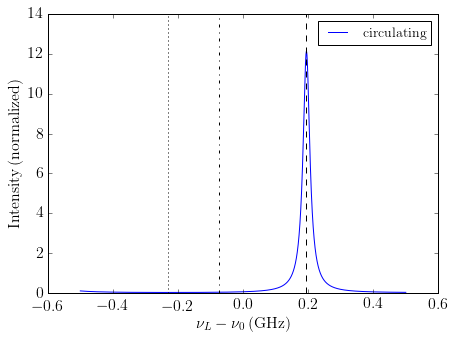

In [99]:
w = det
plt.plot(w/(2*np.pi*1e9),np.absolute(Ecirc(w))**2, label=r'$\mathrm{circulating}$')
plt.xlabel(r'$\nu_L-\nu_0 \, (\mathrm{GHz})$',fontsize=16)
plt.ylabel(r'$\mathrm{Intensity\, (normalized)}$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14)
plt.axvline((detF2_F3)/1e9,linestyle='dashed',color='k')
plt.axvline((detF2_F2)/1e9,linestyle='dashdot',color='k')
plt.axvline((detF2_F1)/1e9,linestyle='dotted',color='k')

$$
\omega \frac{2d}{c}-\cos^{-1}(-\sqrt{g_1 g_2}) = m (2\pi) \quad (m=0,1,2,3,\dots)
$$
$$
\omega_{res}=\left[m (2\pi)+\cos^{-1}\left(-\sqrt{g_1 g_2}\right) \right]\frac{c}{2d}
$$

In [101]:
w0Resonance = (np.arccos(-np.sqrt(g1*g2)))*FSR
grtResonance = np.absolute(grt(w0Resonance))

Finesse = np.pi*np.sqrt(grtResonance)/(1-grtResonance)
print 'Finesse ~ %d' %Finesse

FWHM = ((1-grtResonance)/(np.pi*np.sqrt(grtResonance)))*FSR
print 'FWHM = %.3f MHz' %(FWHM/1e6)
print 'FSR = %.3f GHz' %(FSR/1e9)

Finesse ~ 32
FWHM = 25.382 MHz
FSR = 0.837 GHz


### Reflected Intensity

$$
\frac{\tilde E_\mathrm{circ}}{\tilde E_\mathrm{inc}} = \frac{1}{r_1}\frac{r_1^2-\tilde g_{rt}(\omega_L)}{1-\tilde g_{rt}(\omega_L)}
$$

In [102]:
Eref = lambda det: (1/r1)*(r1**2-grt(det+freqD2))/(1-grt(det+freqD2))

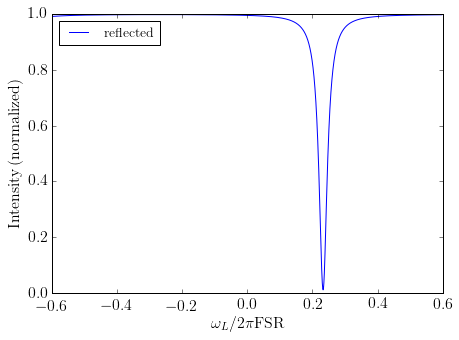

In [103]:
w=det
plt.plot(w/(2*np.pi*FSR),np.absolute(Eref(w))**2, label=r'$\mathrm{reflected}$')
#plt.yscale('log')
plt.xlabel(r'$\omega_L/2\pi \mathrm{FSR}$',fontsize=16)
plt.ylabel(r'$\mathrm{Intensity\, (normalized)}$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(loc='best',fontsize=14)

**Matching conditions:** 

$R_1=R_2 e^{ -2\alpha_0 (2l)}$

The net reflection coefficient becomes zero in the impedance–matched case

Mismatch parameter $\sigma=(1-r_1^2)/(1-r_2^2 e^{ -2\alpha_0 (2l)})=T_1/(1-r_2^2 e^{ -2\alpha_0 (2l)})$ such that
$$
\frac{I_\mathrm{circ}}{I_\mathrm{circ,matched}}=\frac{4\sigma}{(\sigma+1)^2}
$$

In [124]:
sigma = (1-R1)/(1-R2*np.exp(-4*alpha0*d))
ratio_circ = 4*sigma/(sigma+1)**2
ratio_refl = ((sigma-1)/(sigma+1))**2

print 'mismatch: %.2f' %sigma
print 'I_circ/I_matched = %.2f' %ratio_circ

mismatch: 5.22
I_circ/I_matched = 0.54


### Beam shape

Beam size at waist
$$
\omega_0^2 = \left( \frac{\lambda d}{\pi}\right) \frac{\sqrt{g_1 g_2(1-g_1 g_2)}}{g_1+g_2-2g_1 g_2}
$$

at mirrors
$$
\omega^2 = \left( \frac{\lambda d}{\pi}\right) \sqrt{\frac{g_2}{g_1(1-g_1 g_2)}}
$$

In [150]:
print 'Beams sizes:'
print 'waist: %.2f microns' %((np.sqrt((d*probeLambda/np.pi)*np.sqrt((g1*g2*(1 - g1*g2))/(g1 + g2 - 2*g1*g2)**2)))/1e-6)
print 'mirrors: %.2f microns' %((np.sqrt((d*probeLambda/np.pi)*np.sqrt(g1/(g2*(1 - g1*g2)))))/1e-6)

Beams sizes:
waist: 87.24 microns
mirrors: 269.24 microns


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


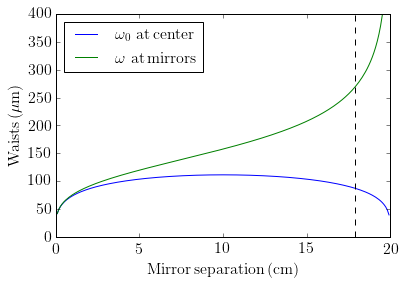

In [151]:
x = np.linspace(0.0,1,1000)

g1x = 1 - x/C1
g2x = 1 - x/C2

w0 = np.sqrt((x*probeLambda/np.pi)*np.sqrt((g1x*g2x*(1 - g1x*g2x))/(g1x + g2x - 2*g1x*g2x)**2))
w1 = np.sqrt((x*probeLambda/np.pi)*np.sqrt(g1x/(g2x*(1 - g1x*g2x))))

plt.plot(x*100,w0*1e6,label=r'$\omega_0\,\, \rm{at\, center}$')
plt.plot(x*100,w1*1e6,label=r'$\omega\,\, \rm{at\, mirrors}$')
plt.axis([0.,20,0.,400])
plt.legend(loc='upper left',fontsize=16)
plt.ylabel(r'$\rm{Waists}\, (\mu m)$', fontsize=16)
plt.xlabel(r'$\rm{Mirror\, separation}\, (cm)$', fontsize=16)
plt.tick_params(labelsize=16)
plt.axvline(d*100,0,400,linestyle='--',color='k')

## Cavity with $^{87}Rb$ vapor cell

In [3]:
grt = lambda det: r1*r2*np.exp(-alpha0*2-ODinterp(det))*np.exp(-1j*(det+freqD2)*2*d/c+1j*np.arccos(-np.sqrt(g1*g2))-1j*phaseshiftInterp(det))
Ecirc = lambda det: t1/(1-grt(det+freqD2))
Etrans = lambda det: t1*t2*np.sqrt(grt(det+freqD2))/((1-grt(det+freqD2))*np.sqrt(r1*r2))

print 'FSR = %.3f GHz' %(FSR/1e9)

NameError: name 'FSR' is not defined

In [58]:
w = det
plt.plot(w/(2*np.pi*1e9),np.absolute(Ecirc(w))**2, label=r'$\mathrm{circulating}$')
plt.plot(w/(2*np.pi*1e9),np.absolute(Etrans(w))**2, label=r'$\mathrm{transmitted}$')
plt.yscale('log')
plt.xlabel(r'$\nu_L-\nu_0 \, (\mathrm{GHz})$',fontsize=16)
plt.ylabel(r'$\mathrm{Intensity\, (normalized)}$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14)
plt.axvline((detF2_F3)/1e9,linestyle='dashed',color='k')
plt.axvline((detF2_F2)/1e9,linestyle='dashdot',color='k')
plt.axvline((detF2_F1)/1e9,linestyle='dotted',color='k')

ValueError: A value in x_new is above the interpolation range.

In [9]:
r2 = np.sqrt(0.99999)
delta = np.linspace(0,0.15,1000,endpoint=True)
r1_99999 = r2*np.exp(-delta)
F_99999 = np.pi*np.sqrt(r1_99999*r2*np.exp(-delta))/(1-r1*r2*np.exp(-delta))
Itrans_99999=1/(1+(2*F_99999/np.pi)**2)

r2 = np.sqrt(0.99)
r1_9999 = r2*np.exp(-delta)
F_9999 = np.pi*np.sqrt(r1_99999*r2*np.exp(-delta))/(1-r1*r2*np.exp(-delta))
Itrans_9999=1/(1+(2*F_9999/np.pi)**2)

r2 = np.sqrt(0.95)
r1_95 = r2*np.exp(-delta)
F_95 = np.pi*np.sqrt(r1_95*r2*np.exp(-delta))/(1-r1*r2*np.exp(-delta))
Itrans_95=1/(1+(2*F_95/np.pi)**2)

r2 = np.sqrt(0.90)
r1_9 = r2*np.exp(-delta)
F_9 = np.pi*np.sqrt(r1_9*r2*np.exp(-delta))/(1-r1*r2*np.exp(-delta))
Itrans_9=1/(1+(2*F_9/np.pi)**2)

[0, 0.15, 0, 50]

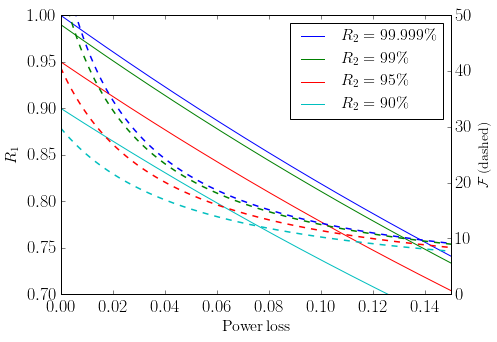

In [10]:
fig, ax1 = plt.subplots()
ax1.plot(delta,r1_99999**2,label=r'$R_2=99.999\%$')
ax1.plot(delta,r1_9999**2,label=r'$R_2=99\%$')
ax1.plot(delta,r1_95**2,label=r'$R_2=95\%$')
ax1.plot(delta,r1_9**2,label=r'$R_2=90\%$')
ax1.set_xlabel(r'$\mathrm{Power\, loss}$', fontsize=16)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel(r'$R_1$', fontsize=16)
ax1.legend(fontsize=16)
ax1.axis([0,0.15,0.7,1])
for tl in ax1.get_yticklabels():
    tl.set_fontsize(18)
for tl in ax1.get_xticklabels():
    tl.set_fontsize(18)
    
ax2 = ax1.twinx()
plt.plot(delta,F_99999,'--',lw=1.5)
plt.plot(delta,F_9999,'--',lw=1.5)
plt.plot(delta,F_95,'--',lw=1.5)
plt.plot(delta,F_9,'--',lw=1.5)
ax2.set_ylabel(r'$\mathcal{F}\, \mathrm{(dashed)}$', fontsize=14)
for tl in ax2.get_yticklabels():
    tl.set_fontsize(18)
ax2.axis([0,0.15,0,50])



#plt.savefig('finesse.png')

In [41]:
def Itrans(delta, R1,fractionLossTrans):
    ratio = fractionLossTrans*np.exp(-delta)
    grt = np.sqrt( R1*np.exp(-2*delta)*(1-ratio) )
    t1 = np.sqrt(1-R1)
    return (ratio*t1/(1-grt))**2

def finesse(delta,R1, fractionLossTrans):
    ratio = fractionLossTrans*np.exp(-delta)
    grt = np.sqrt( R1*np.exp(-2*delta)*(1-ratio) )
    return np.pi*np.sqrt(grt)/(1-grt)

In [42]:
delta = np.linspace(0,0.15,1000,endpoint=True)
R1 = np.linspace(0.,1,1000,endpoint=False)
X,Y = np.meshgrid(delta, R1)

flt = 0.1
Z1 = Itrans(X, Y, flt)
Z2 = finesse(X, Y, flt)

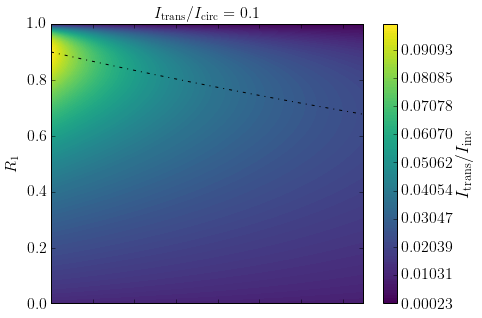

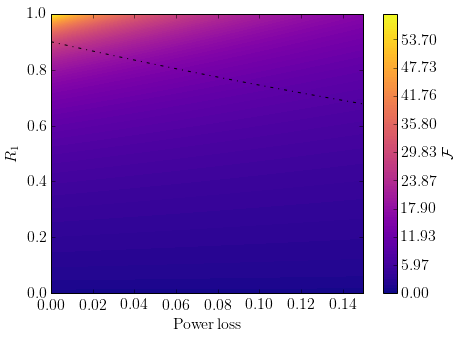

In [43]:
plt.figure()
plt.contourf(X,Y,Z1,levels=np.linspace(Z1.min(),Z1.max(),100),cmap=plt.cm.viridis)
#plt.xlabel(r'$\mathrm{Power\, loss}$', fontsize=16)
plt.ylabel(r'$R_1$', fontsize=16)
plt.title('$I_\mathrm{trans}/I_\mathrm{circ} = '+str(flt)+'$', fontsize=16)
plt.tick_params(labelsize=16,labelbottom=False)
cbar = plt.colorbar()
cbar.set_label(label=r'$I_\mathrm{trans}/I_\mathrm{inc}$',size=18)
cbar.ax.tick_params(labelsize=16) 
InputMatched = (1-flt*np.exp(-delta))*np.exp(-2*delta)
plt.plot(delta,InputMatched,'k-.')

plt.figure()
plt.contourf(X,Y,Z2,levels=np.linspace(Z2.min(),Z2.max(),100),cmap=plt.cm.plasma)
plt.xlabel(r'$\mathrm{Power\, loss}$', fontsize=16)
plt.ylabel(r'$R_1$', fontsize=16)
plt.tick_params(labelsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r'$\mathcal{F}$',size=16)
cbar.ax.tick_params(labelsize=16) 
plt.plot(delta,InputMatched,'k-.')

In [46]:
delta = 0.04

R1 = np.linspace(0,1,1000)
ratio = flt*np.exp(-delta)

T2=ratio*np.exp(delta)
trans = ((np.sqrt(1 - R1)*ratio)/(1 - np.sqrt(R1*np.exp(-2*delta)*(1 - ratio*np.exp(delta)))))**2
grt = np.sqrt( R1*np.exp(-2*delta)*(1-ratio*np.exp(delta)) )
finesse = np.pi*np.sqrt(grt)/(1-grt)

ItransMax = (ratio**2*np.exp(-delta)*(ratio+2*np.sinh(delta)))/(1-np.sqrt(np.exp(-4*delta)*(np.exp(delta)*ratio-1)**2))**2
Rmax = np.exp(-2*delta)*(1-np.exp(delta)*ratio)

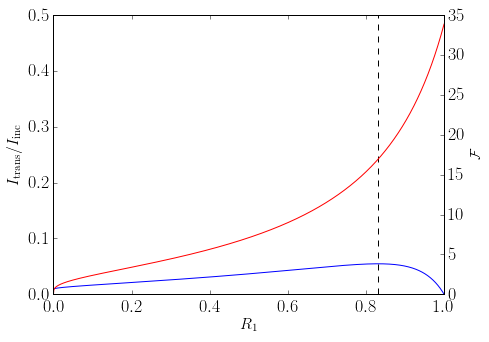

In [47]:
fig, ax1 = plt.subplots()
ax1.plot(R1,trans)
ax1.set_xlabel(r'$R_1$', fontsize=16)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel(r'$I_\mathrm{trans}/I_\mathrm{inc}$', fontsize=16)
ax1.axis([0,1,0.,0.5])
#plt.axvline(Rmax,color='k',ls='dashed')
plt.axvline((1-T2)*np.exp(-2*delta),color='k',ls='dashed')
for tl in ax1.get_yticklabels():
    tl.set_fontsize(18)
for tl in ax1.get_xticklabels():
    tl.set_fontsize(18)
    
ax2 = ax1.twinx()
plt.plot(R1,finesse,'r-')
ax2.set_ylabel(r'$\mathcal{F}$', fontsize=14)
for tl in ax2.get_yticklabels():
    tl.set_fontsize(18)
#ax2.axis([0,0.15,0,50])

In [39]:
np.log(1/0.9)

0.10536051565782635